In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

clean_lines = []
for dirname, _, filenames in os.walk('/kaggle/input/chest-xray-masks-and-labels/data/Lung Segmentation/ClinicalReadings'):
    for i in range(len(filenames)):
        path = os.path.join(dirname, filenames[i])
        with open(path, "r") as file:
            clean_lines.append([])
            clean_lines[i].append(filenames[i].split(".")[0])
            clean_lines[i] += [line.replace("\t", "").replace("\n", "").replace("yrs", "").replace("yr", "") for line in file.readlines()]
            for j in range(len(clean_lines[i])):
                clean_lines[i][j] = "".join(clean_lines[i][j].rstrip().lstrip())
                if j == 1:
                    clean_lines[i][j] = clean_lines[i][j].split(" ")
#             clean_lines[i] = [clean_lines[i][0], *clean_lines[i][1], *clean_lines[i][2:]]
            clean_lines[i] = [clean_lines[i][0], *clean_lines[i][1]]

def print_unique_col_values(df):
    for column in df:
        print(column, df[column].unique())
# clean_lines           
df = pd.DataFrame(clean_lines)
df.drop(3, axis=1, inplace=True)
# df.drop(5, axis=1, inplace=True)
# df.drop(6, axis=1, inplace=True)
df.columns = ["Filecode", "Sex", "Age"]
# df
for drop_value in ["16month", "64days"]:
    df.drop(df[df.Age == drop_value].index, inplace=True)
df.drop(df[df.Sex == "Patient's"].index, inplace=True)

df.Age = pd.to_numeric(df.Age, errors="coerce")
df.drop(df[df.Age != df.Age].index, inplace=True) # remove nan
df.Age = df.Age / 100

df.Sex.replace({
    "male": 0,
    "Male": 0,
    "Male,": 0,
    "female": 1,
    "Female": 1,
    "Female,": 1,
    "femal": 1,
}, inplace=True)

df.insert(0, "Status", [0 for _ in range(len(df))])

column = []
for _, row in df.iterrows():
    row.Status = int(row.Filecode[12])
    column.append(row.Status)
df.Status = np.array(column)
    
print_unique_col_values(df)
print(df.dtypes)
print(df.Status.value_counts())

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Status [1 0]
Filecode ['CHNCXR_0499_1' 'CHNCXR_0120_0' 'CHNCXR_0192_0' 'CHNCXR_0548_1'
 'CHNCXR_0119_0' 'CHNCXR_0403_1' 'CHNCXR_0368_1' 'CHNCXR_0190_0'
 'CHNCXR_0615_1' 'CHNCXR_0047_0' 'CHNCXR_0260_0' 'CHNCXR_0150_0'
 'CHNCXR_0313_0' 'CHNCXR_0148_0' 'CHNCXR_0306_0' 'CHNCXR_0416_1'
 'CHNCXR_0432_1' 'CHNCXR_0444_1' 'CHNCXR_0031_0' 'CHNCXR_0307_0'
 'CHNCXR_0335_1' 'CHNCXR_0404_1' 'CHNCXR_0083_0' 'CHNCXR_0537_1'
 'CHNCXR_0016_0' 'CHNCXR_0607_1' 'CHNCXR_0637_1' 'CHNCXR_0518_1'
 'CHNCXR_0396_1' 'CHNCXR_0053_0' 'CHNCXR_0097_0' 'CHNCXR_0479_1'
 'CHNCXR_0470_1' 'CHNCXR_0301_0' 'CHNCXR_0135_0' 'CHNCXR_0189_0'
 'CHNCXR_0218_0' 'CHNCXR_0036_0' 'CHNCXR_0002_0' 'CHNCXR_0612_1'
 'CHNCXR_0431_1' 'CHNCXR_0066_0' 'CHNCXR_0593_1' 'CHNCXR_0442_1'
 'CHNCXR_0210_0' 'CHNCXR_0391_1' 'CHNCXR_0567_1' 'CHNCXR_0255_0'
 'CHNCXR_0237_0' 'CHNCXR_0235_0' 'CHNCXR_0505_1' 'CHNCXR_0188_0'
 'CHNCXR_0059_0' 'CHNCXR_0466_1' 'CHNCXR_0349_1' 'CHNCXR_0455_1'
 'CHNCXR_0336_1' 'CHNCXR_0642_1' 'CHNCXR_0350_1' 'CHNCXR_0498_1'
 'C

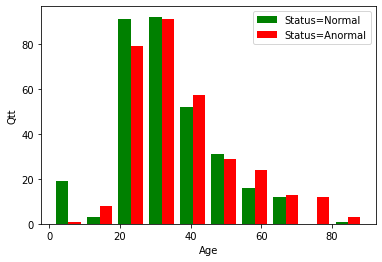

In [2]:
import matplotlib.pyplot as plt

balanced_Status_normal = df[df.Status == 0]
balanced_Status_anormal = df[df.Status == 1][:len(balanced_Status_normal)]

plt.xlabel('Age')
plt.ylabel('Qtt')
plt.hist([balanced_Status_normal.Age*100, balanced_Status_anormal.Age*100], color=['green', 'red'], label=['Status=Normal', 'Status=Anormal'])
plt.legend()

In [3]:
import cv2

balanced_dataset = pd.concat([balanced_Status_normal, balanced_Status_anormal])
balanced_dataset = balanced_dataset.sample(frac=1).reset_index(drop=True)

IMG_SIZE = (256,256)
xray_folder = "/kaggle/input/chest-xray-masks-and-labels/data/Lung Segmentation/CXR_png/"
masks_folder = "/kaggle/input/chest-xray-masks-and-labels/data/Lung Segmentation/masks/"
X, y = [], []
for _, row in balanced_dataset.iterrows():
    xray_path = xray_folder+row.Filecode+".png"
#     mask_path = masks_folder+row.Filecode+"_mask.png"
#     img = cv2.imread(xray_path)
#     mask = cv2.imread(mask_path, 0)
#     X.append(cv2.resize(cv2.bitwise_and(img, img, mask=mask), IMG_SIZE))
    X.append(cv2.resize(cv2.imread(xray_path), IMG_SIZE))
    y.append(row.Status)

In [4]:
def zoom(img, zoom_factor=.3):
    return cv2.resize(img, None, fx=zoom_factor, fy=zoom_factor)

alpha = 1
beta = 0
# for i in range(len(X)):
#     X[i] = cv2.addWeighted(X[i], alpha, X[i], 0, beta)    
#     X[i] = cv2.bitwise_not(X[i])
#     X[i] = zoom(X[i][30:-30, 30:-30])

1


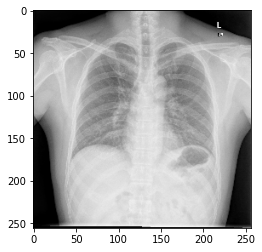

In [5]:
def zoom(img, zoom_factor=.3):
    return cv2.resize(img, None, fx=zoom_factor, fy=zoom_factor)

# img_test = X[20][30:-30, 30:-30]
# plt.imshow(zoom(img_test))
plt.imshow(X[20])
print(y[80])

In [6]:
X = np.array(X) / 255
# X_ = X_[..., np.newaxis]
y = np.array(y)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((507, 256, 256, 3), (127, 256, 256, 3), (507,), (127,))

In [7]:
from tensorflow import keras

model = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), input_shape=IMG_SIZE+(3,), padding="same", activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(.2),
    
    keras.layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(.2),
    
    keras.layers.Conv2D(128, (3,3), padding="same", activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(.2),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512),
    keras.layers.Dense(128),
    keras.layers.Dense(64),
    keras.layers.Dense(32),
    keras.layers.Dense(16),
    keras.layers.Dense(1, activation="sigmoid"),
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    x=X_train, 
    y=y_train, 
    epochs=15
)

Epoch 1/15
16/16 [==============================] - 8s 70ms/step - loss: 16.8182 - accuracy: 0.4931
Epoch 2/15
16/16 [==============================] - 1s 46ms/step - loss: 0.6542 - accuracy: 0.6134
Epoch 3/15
16/16 [==============================] - 1s 46ms/step - loss: 0.7010 - accuracy: 0.6746
Epoch 4/15
16/16 [==============================] - 1s 45ms/step - loss: 0.5585 - accuracy: 0.7239
Epoch 5/15
16/16 [==============================] - 1s 46ms/step - loss: 0.4993 - accuracy: 0.7653
Epoch 6/15
16/16 [==============================] - 1s 48ms/step - loss: 0.4741 - accuracy: 0.7811
Epoch 7/15
16/16 [==============================] - 1s 45ms/step - loss: 0.4630 - accuracy: 0.7949
Epoch 8/15
16/16 [==============================] - 1s 45ms/step - loss: 0.4369 - accuracy: 0.8107
Epoch 9/15
16/16 [==============================] - 1s 46ms/step - loss: 0.4084 - accuracy: 0.8264
Epoch 10/15
16/16 [==============================] - 1s 45ms/step - loss: 0.3982 - accuracy: 0.8481
Epoch 11

In [8]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 93ms/step - loss: 0.4435 - accuracy: 0.8346


[0.4435249865055084, 0.834645688533783]

In [9]:
from sklearn.metrics import confusion_matrix, classification_report

y_predicted = model.predict(X_test)
y_predicted_rounded = []
for v in y_predicted:
    if v >= .5:
        y_predicted_rounded.append(1)
        continue
    y_predicted_rounded.append(0)
    
print(classification_report(y_test, y_predicted_rounded))

              precision    recall  f1-score   support

           0       0.84      0.85      0.84        67
           1       0.83      0.82      0.82        60

    accuracy                           0.83       127
   macro avg       0.83      0.83      0.83       127
weighted avg       0.83      0.83      0.83       127



Text(69.0, 0.5, 'Truth')

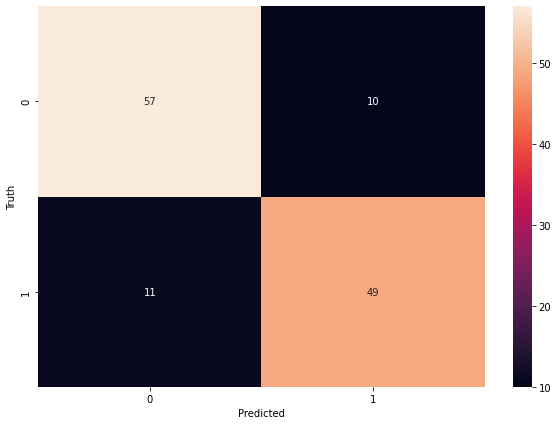

In [10]:
import seaborn as sn
import tensorflow as tf

cm = tf.math.confusion_matrix(labels=y_test, predictions=y_predicted_rounded)
plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [11]:
for i in range(len(y_predicted_rounded)):
    if y_predicted_rounded[i] == y_test[i]:
        continue
    print(i, y_predicted_rounded[i], y_test[i])

0 1 0
27 0 1
28 1 0
32 1 0
34 0 1
46 0 1
48 1 0
53 1 0
56 1 0
62 0 1
63 0 1
68 1 0
75 0 1
77 0 1
83 1 0
95 0 1
100 0 1
109 0 1
114 1 0
117 1 0
119 0 1


In [12]:
# model.save("model.h5")

In [13]:
# from tensorflow import keras
# model = keras.models.load_model("./model.h5")

In [14]:
import cv2
import numpy as np
import seaborn as sn
import tensorflow as tf

def test_folder(folder, exp):
    imgs = []
    y_exp = []
    for dirname, _, filenames in os.walk(folder):
        for i in range(len(filenames)):
            if i > 500:
                break
            path = os.path.join(dirname, filenames[i])
            imgs.append(cv2.resize(cv2.imread(path), (256,256)))
            y_exp.append(exp)

    imgs = np.array(imgs) / 255
    print(imgs.shape)
#     imgs = imgs[np.newaxis, ...]
#     y_exp = y_exp[np.newaxis, ...]
            
    from sklearn.metrics import confusion_matrix, classification_report

    y_predicted = model.predict(imgs)
    y_predicted_rounded = []
    for v in y_predicted:
        if v >= .5:
            y_predicted_rounded.append(1)
            continue
        y_predicted_rounded.append(0)

    print(classification_report(y_exp, y_predicted_rounded))

    cm = tf.math.confusion_matrix(labels=y_exp, predictions=y_predicted_rounded)
    plt.figure(figsize=(10,7))
    sn.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')

(501, 256, 256, 3)


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.29      0.45       501

    accuracy                           0.29       501
   macro avg       0.50      0.14      0.22       501
weighted avg       1.00      0.29      0.45       501



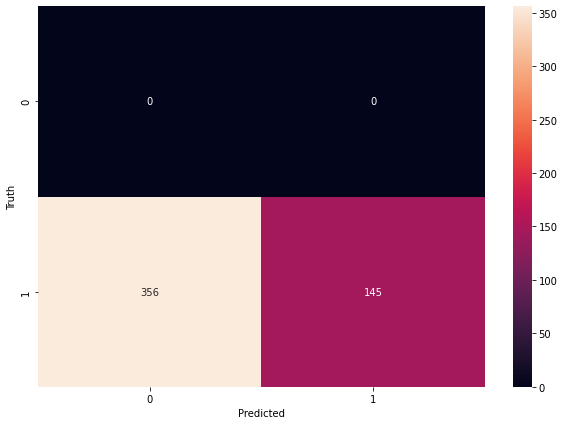

In [15]:
test_folder("../input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis", 1)

(501, 256, 256, 3)


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      0.67      0.80       501
           1       0.00      0.00      0.00         0

    accuracy                           0.67       501
   macro avg       0.50      0.33      0.40       501
weighted avg       1.00      0.67      0.80       501



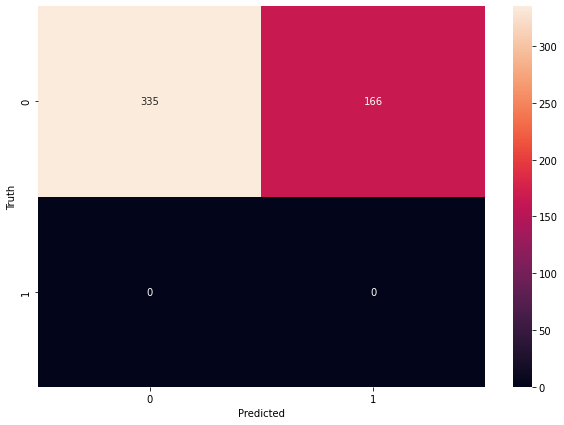

In [16]:
test_folder("../input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Normal", 0)